# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (morfemy). W przeciwieństwie do podejść lingwistycznych, wymagających reguł tworzenia morfemów, BPE wyznacza je automatycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków które występują obok siebie.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20) razy
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10) razy
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technike BPE na tych słowach.

Zaimplementuj algorytm BPE wykonujący `number_of_iterations` iteracji (łączeń symboli).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [39]:
import re

import pandas as pd
import numpy as np

brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])


def find_pairs(word, multiplier):
    pairs_dct = dict()
    symbols = word.split(' ')

    for i in range(len(symbols) - 1):
        key = f"{symbols[i]} {symbols[i + 1]}"
        pairs_dct[key] = pairs_dct.get(key, 0) + multiplier

    return pairs_dct


def preform_bpe(data_df, number_of_iterations):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    data_df['word'] = data_df['word'].fillna('')
    data_df['word'] = data_df['word'].apply(lambda word: ' '.join(list(word)) + ' END')

    pairs_global_dct = dict()
    for index, row in data_df.iterrows():
        word_pairs_dct = find_pairs(row['word'], row['count'])
        for k in word_pairs_dct.keys():
            pairs_global_dct[k] = pairs_global_dct.get(k, 0) + word_pairs_dct[k]

    for _ in range(number_of_iterations):
        top_pair = max(pairs_global_dct, key=pairs_global_dct.get)
        top_pair_merged = top_pair.replace(" ", "")
        # print("New symbol:", top_pair)
        influenced_df = data_df[data_df['word'].str.contains(top_pair, regex=False)]
        data_df['word'] = data_df['word'].str.replace(top_pair, top_pair_merged, regex=False)

        for index, row in influenced_df.iterrows():

            word_pairs_dct = find_pairs(row['word'], row['count'])
            for k in word_pairs_dct.keys():
                pairs_global_dct[k] = pairs_global_dct.get(k, 0) - word_pairs_dct[k]

            word_pairs_dct = find_pairs(data_df.loc[index, 'word'], row['count'])
            for k in word_pairs_dct.keys():
                pairs_global_dct[k] = pairs_global_dct.get(k, 0) + word_pairs_dct[k]

    return data_df["word"].values.tolist()

Test implementacji:

In [36]:
from nose.tools import assert_list_equal

data = {'cluster': range(2), 'word': ['ala', 'mama'], 'count': [5, 10]}
df = pd.DataFrame(data, columns=['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [38]:
preform_bpe(brown_df, 50)

New symbol: e END
New symbol: t END
New symbol: s END
New symbol: i n
New symbol: t h
New symbol: d END
New symbol: y END
New symbol: . END
New symbol: o END
New symbol: r END
New symbol: > END
New symbol: a n
New symbol: o n
New symbol: o u
New symbol: g END
New symbol: a END
New symbol: l END
New symbol: in gEND
New symbol: < @
New symbol: M E
New symbol: N T
New symbol: I O
New symbol: N >END
New symbol: <@ ME
New symbol: NT IO
New symbol: <@ME NTIO
New symbol: <@MENTIO N>END
New symbol: r e
New symbol: i END
New symbol: th eEND
New symbol: e n
New symbol: o m
New symbol: t oEND
New symbol: , END
New symbol: ! END
New symbol: h a
New symbol: e rEND
New symbol: i t
New symbol: : END
New symbol: y ou
New symbol: a l
New symbol: o w
New symbol: . .END
New symbol: s t
New symbol: k END
New symbol: e r
New symbol: i sEND
New symbol: f END
New symbol: on END
New symbol: in END


['\\ iEND',
 '/ i / END',
 't o d a y - iEND',
 'n ow iEND',
 '# you e v erEND',
 'i f in al l yEND',
 '「 iEND',
 '- i - END',
 'in e v aEND',
 '» iEND',
 'w ha t t a y aEND',
 'i i i i i i i i i iEND',
 '\ue6d1 END',
 'i k in d aEND',
 'l o l - iEND',
 'i a c t u al l yEND',
 'w a d d y aEND',
 '# a s l on g a s you END',
 'd o you END',
 '\u200e \u200b iEND',
 'i ̇ END',
 'ï END',
 '# l o l a t g i r l s w h oEND',
 '# r t i f you END',
 'i j stEND',
 '« iEND',
 '• iEND',
 'w h o d aEND',
 'w ha d y aEND',
 ') iEND',
 '+ iEND',
 '# you r f a c e m a k e s m eEND',
 'i i i i i i i iEND',
 '` iEND',
 'i i i i i i iEND',
 'i al re a d yEND',
 '_ iEND',
 '# you m a k e m eEND',
 '* iEND',
 '| iEND',
 '# u r b o y f r i en d e v erEND',
 'w h en iEND',
 'ι END',
 "d on ' t c haEND",
 "w h o ' d aEND",
 'd you END',
 'w ha d d a y aEND',
 'i on l yEND',
 'i j u s sEND',
 'i al w a y sEND',
 'i i i i iEND',
 'd on c haEND',
 '( iEND',
 "d ' y aEND",
 'ı END',
 '# u e v erEND',
 'in e v erEN

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

Najszybciej swój token dostało słowo "in", jeżeli jednak nie liczymy go jako słowa będzie to następne w kolejce "MENTION".

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji (problem OOV, odnieś się do  k-gramów i n-gramów)?

Zaletą korzystania z BPE w kontekście problemu OOV jest z pewnością fakt, że tokenizujemy najczęściej występujące pary symboli a nie całe słowa, co pozwala rozwiązać problem literówek. Kolejną zaletą możę być to, że potrzebujemy mniejszej wiedzy na temat danego języka w przeciwieństwie do n-gramów, ponieważ tutaj tworzenie tokenów odbywa się od podstaw automatycznie. Odnosząc się natomiast to k-gramów, reprezentacja BPE jest znacznie bardziej efektywne (wymaga mniejszej ilości cech).

Wróć do implementacji i zakomentuj wypisywanie (funkcje print) informacji z funkcji `preform_bpe`.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [40]:
from helpers import DataSet

training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [41]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update? C'mon.
['dear', '@microsoft', 'the', 'newooffice', 'for', 'mac', 'is', 'great', 'and', 'all', ',', 'but', 'no', 'lync', 'update', '?', "c'mon", '.']
negative


Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz przykłady uczące na cechy rośnie do bardzo dużych rozmiarów nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator (najlepiej taki, który się szybko liczy) na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [42]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.feature_extraction import FeatureHasher
import re


def process_data(data, n_features):
    tokens_per_text = []

    c = Counter()
    for tokens in [word_tokenize(obj.text.lower()) for obj in data]:
        c.update(tokens)
        tokens_per_text.append(tokens)

    for k in list(c.keys()):
        if re.findall("\W", k) != [] or k in stopwords.words('english'):
            c.pop(k)

    most_common = [x[0] for x in c.most_common(n_features)]

    data_out = []
    for tokens in tokens_per_text:
        cc = Counter()
        cc.update(tokens)

        for key in list(cc.keys()):
            if key not in most_common:
                cc.pop(key)

        data_out.append(dict(cc))

    return FeatureHasher(n_features=n_features).fit_transform(data_out, y).toarray()


n_features = 100
y = np.array([y.clazz for y in training_set.tweets])
X = process_data(training_set.tweets, n_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.5216426193118757


- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

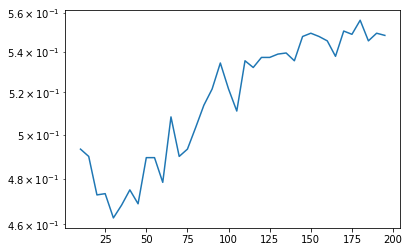

In [43]:
import matplotlib.pyplot as plt

scores = []
n_features = range(10, 200, 5)

for i in n_features:
    y = np.array([y.clazz for y in training_set.tweets])
    X = process_data(training_set.tweets, i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

plt.plot(list(n_features), scores)
plt.yscale("log")

 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

Generalny wynik klasyfikacji należy zaliczyć do słabych, ponieważ maksymalna trafność wyniosła ok. 55% (co jest wynikiem niewiele lepszym od algorytmu losowego). Wraz ze wzrostem ilości cech zyskujemy również poprawę jakości klasyfikacji (której jakość ciężko ocenić ze względu niski wynik od samego początku). Skonfliktowane cechy nie powodują spadku jakości klasyfikacji, ponieważ kolizje są powodowane przez to że podobne symbole mają podobne wartości funkcji haszowej, a jeżeli są podobne do siebie to można również podejrzewać że są podobne znaczeniowo i mają bliskoznaczne znaczenie dla danego tekstu.

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [44]:
from pandas import DataFrame

c = Counter()
for row in training_set.tweets:
    c.update(row.tokens)

tweets_df = DataFrame.from_dict({'word': c.keys(), 'count': c.values()})
data = preform_bpe(tweets_df, 20)

feature_names = set()
for x in data:
    feature_names.update(set(x.split(' ')))

y = np.array([y.clazz for y in training_set.tweets])
X = pd.DataFrame(columns=feature_names, data=np.zeros(shape=(y.shape[0], len(feature_names)), dtype=int))
for i in range(y.shape[0]):
    for fn in feature_names:
        if training_set.tweets[i].text.find(fn) != -1:
            X.iloc[i][fn] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.52330743618202


- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

Uzyskanie rezultaty klasyfikacji dla obu metod są równie złe dla obu metod, zapewne jest to wina implementacji i jakichś błędów których nie dostrzegam, dlatego na pytania odpowiem teoretycznie. Zaletą FeatureHashera jest to, że można precyzyjnie ustalić ilość cech i na tej podstawie dobrać ten parametr dla jak najlepszego wyniku klasyfikacji. Nie można tego samego powiedzieć o BPE, dla którego trzeba dobrać odpowiednią ilość iteracji. Zaletą BPE pozostaje w dalszym ciągu automatyzacja przetwarzania, co uniezależnia go niejako o problemu w generowaniu poprawnych tokenów. W przypadku FH wiele zależy od tokenizacji.